## CELL 1: Mount Google Drive

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

print("✅ Google Drive mounted!")
print("\n💡 Dataset structure expected:")
print("   /content/drive/MyDrive/CropSense AI/dataset/Test/")
print("      ├── Healthy/")
print("      ├── Powdery/")
print("      └── Rust/")


Mounted at /content/drive
✅ Google Drive mounted!

💡 Dataset structure expected:
   /content/drive/MyDrive/CropSense AI/dataset/Test/
      ├── Healthy/
      ├── Powdery/
      └── Rust/


## CELL 2: Project Overview

In [2]:
"""
═══════════════════════════════════════════════════════════════════════════
CROPSENSE AI - CROP DISEASE DETECTION MODEL
═══════════════════════════════════════════════════════════════════════════

Project: AI-Driven Decision Support for Climate-Resilient Smallholder Farming
Author: Diana RUZINDANA
Supervisor: Marvin Muyonga Ogore
Date: January 2026
Institution: BSc. Software Engineering

Dataset: Plant Disease Classification
Source: https://www.kaggle.com/code/vad13irt/plant-disease-classification/input

Models Compared:
  1. MobileNetV2  - Lightweight, mobile-optimized
  2. VGG16        - Deep CNN, high accuracy baseline
  3. ResNet50     - Residual connections, strong generalisation
═══════════════════════════════════════════════════════════════════════════
"""

from IPython.display import display, Markdown
display(Markdown("""
# CropSense AI - Multi-Model Disease Detection

## Project Overview
CNN-based crop disease detection for smallholder farmers in Rwanda.
Three pre-trained models are compared and the best is selected.

## Models
| Model | Parameters | Strength |
|-------|-----------|---------|
| MobileNetV2 | ~3.4M | Fastest, mobile-ready |
| VGG16 | ~138M | Strong feature extraction |
| ResNet50 | ~25M | Best generalisation |
"""))



# CropSense AI - Multi-Model Disease Detection

## Project Overview
CNN-based crop disease detection for smallholder farmers in Rwanda.
Three pre-trained models are compared and the best is selected.

## Models
| Model | Parameters | Strength |
|-------|-----------|---------|
| MobileNetV2 | ~3.4M | Fastest, mobile-ready |
| VGG16 | ~138M | Strong feature extraction |
| ResNet50 | ~25M | Best generalisation |


## CELL 3: Import Libraries

In [3]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 3: IMPORT LIBRARIES
# ═══════════════════════════════════════════════════════════════════════════

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from pathlib import Path
import warnings
import json
from datetime import datetime
warnings.filterwarnings('ignore')

# Image processing
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, auc, accuracy_score)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2, VGG16, ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Style
plt.style.use('default')
sns.set_palette("husl")
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("="*80)
print("ENVIRONMENT SETUP".center(80))
print("="*80)
print(f"TensorFlow: {tf.__version__}")
print(f"NumPy:      {np.__version__}")
print(f"Pandas:     {pd.__version__}")

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\n✅ GPU Available: {len(gpus)} device(s)")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("\n⚠️  No GPU - Enable in Runtime → Change runtime type")
print("="*80)


                               ENVIRONMENT SETUP                                
TensorFlow: 2.19.0
NumPy:      2.0.2
Pandas:     2.2.2

⚠️  No GPU - Enable in Runtime → Change runtime type


## CELL 4: Configuration Parameters

In [4]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 4: CONFIGURATION PARAMETERS
# ═══════════════════════════════════════════════════════════════════════════

# Paths
BASE_DIR         = '/content/drive/MyDrive/CropSense AI/dataset/Test'
CROP_CALENDAR_CSV = '/content/drive/MyDrive/CropSense AI/Rwanda_Crop_calendar_Data.csv'
OUTPUT_DIR       = '/content/drive/MyDrive/CropSense AI/outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Classes (auto-detected later)
CLASSES = ['Healthy', 'Powdery', 'Rust']

# Image parameters
IMG_HEIGHT   = 224
IMG_WIDTH    = 224
IMG_SIZE     = (IMG_HEIGHT, IMG_WIDTH)
IMG_CHANNELS = 3
BATCH_SIZE   = 32

# Training parameters
INITIAL_EPOCHS    = 25
FINE_TUNE_EPOCHS  = 15
TOTAL_EPOCHS      = INITIAL_EPOCHS + FINE_TUNE_EPOCHS
INITIAL_LR        = 0.001
FINE_TUNE_LR      = 0.0001
FINE_TUNE_AT      = 100   # Layer index to start unfreezing from

# Custom head architecture
DROPOUT_1 = 0.3
DENSE_1   = 256
DROPOUT_2 = 0.4
DENSE_2   = 128
DROPOUT_3 = 0.3

# Data split
TEST_SIZE = 0.2
VAL_SIZE  = 0.2

# Callbacks
EARLY_STOP_PATIENCE = 7
REDUCE_LR_PATIENCE  = 3
REDUCE_LR_FACTOR    = 0.5
MIN_LR              = 1e-7

# Output paths
CHECKPOINT_DIR   = OUTPUT_DIR
METADATA_PATH    = f'{OUTPUT_DIR}/model_metadata.json'
TFLITE_PATH      = f'{OUTPUT_DIR}/cropsense_best_model.tflite'

print("="*80)
print("CONFIGURATION SUMMARY".center(80))
print("="*80)
print(f"  Dataset:     {BASE_DIR}")
print(f"  Output:      {OUTPUT_DIR}")
print(f"  Image size:  {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"  Batch size:  {BATCH_SIZE}")
print(f"  Phase 1:     {INITIAL_EPOCHS} epochs @ LR={INITIAL_LR}")
print(f"  Phase 2:     {FINE_TUNE_EPOCHS} epochs @ LR={FINE_TUNE_LR}")
print(f"  Split:       {int((1-TEST_SIZE)*(1-VAL_SIZE)*100)}% train / {int((1-TEST_SIZE)*VAL_SIZE*100)}% val / {int(TEST_SIZE*100)}% test")
print("="*80)


                             CONFIGURATION SUMMARY                              
  Dataset:     /content/drive/MyDrive/CropSense AI/dataset/Test
  Output:      /content/drive/MyDrive/CropSense AI/outputs
  Image size:  224x224
  Batch size:  32
  Phase 1:     25 epochs @ LR=0.001
  Phase 2:     15 epochs @ LR=0.0001
  Split:       64% train / 16% val / 20% test


## CELL 5: Load Rwanda Crop Calendar

In [5]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 5: LOAD RWANDA CROP CALENDAR DATA
# ═══════════════════════════════════════════════════════════════════════════

print("="*80)
print("LOADING RWANDA CROP CALENDAR DATA".center(80))
print("="*80)

if os.path.exists(CROP_CALENDAR_CSV):
    crop_calendar = pd.read_csv(CROP_CALENDAR_CSV)
    print(f"\n✅ Loaded: {crop_calendar.shape[0]:,} rows × {crop_calendar.shape[1]} columns")
    print(f"\n📋 Columns: {list(crop_calendar.columns)}")
    print(f"\n📊 Preview:")
    print(crop_calendar.head())

    # Categorical summary
    cat_cols = crop_calendar.select_dtypes(include='object').columns
    for col in cat_cols[:5]:
        uq = crop_calendar[col].nunique()
        print(f"   {col}: {uq} unique values", end="")
        if uq <= 10:
            print(f" → {crop_calendar[col].unique().tolist()}", end="")
        print()

    crop_calendar.to_csv(f'{OUTPUT_DIR}/loaded_crop_calendar.csv', index=False)
    print(f"\n💾 Saved copy to: {OUTPUT_DIR}/loaded_crop_calendar.csv")
else:
    print(f"\n⚠️  CSV not found at: {CROP_CALENDAR_CSV}")
    print("   Disease detection will still work — recommendations won't be season-aware.")
    crop_calendar = None

print("="*80)


                       LOADING RWANDA CROP CALENDAR DATA                        

✅ Loaded: 97 rows × 25 columns

📋 Columns: ['Crop', 'AgroEcological Zone', 'Additional information', 'Early Sowing', 'Unnamed: 4', 'Later Sowing', 'Unnamed: 6', 'All year', 'Sowing rate', 'Unnamed: 9', 'Growing period', 'Unnamed: 11', 'Early harvest', 'Unnamed: 13', 'Late harvest', 'Unnamed: 15', 'AgroEcological Zone Description', 'AgroEcological Zone Practices', 'AgroEcological Zone Units', 'Comments En', 'Comments ES', 'Comments FR', 'Comments ZH', 'Comments AR', 'Comments RU']

📊 Preview:
                     Crop AgroEcological Zone  \
0                     NaN                 NaN   
1  Beans, harvested green                Imbo   
2                 Cassava                Imbo   
3                Pea, dry                Imbo   
4                    Corn                Imbo   

                              Additional information Early Sowing Unnamed: 4  \
0                                             

## CELL 6: Data Loading & Cleaning

In [6]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 6: AUTO-DETECT CLASSES, CLEAN & LOAD DATA
# ═══════════════════════════════════════════════════════════════════════════

print("="*80)
print("DATASET LOADING & CLEANING".center(80))
print("="*80)

# ── Auto-detect classes ──────────────────────────────────────────────────
print("\n🔍 Auto-detecting classes...")
if not os.path.exists(BASE_DIR):
    raise FileNotFoundError(f"Dataset not found: {BASE_DIR}")

CLASSES = sorted([d for d in os.listdir(BASE_DIR)
                  if os.path.isdir(os.path.join(BASE_DIR, d))])
if not CLASSES:
    raise ValueError("No class folders found!")

print(f"✅ Found {len(CLASSES)} classes:")
for i, cls in enumerate(CLASSES, 1):
    n = len([f for f in os.listdir(os.path.join(BASE_DIR, cls))
             if f.lower().endswith(('.jpg','.jpeg','.png'))])
    print(f"   {i}. {cls} ({n:,} images)")

# ── Clean corrupted images ───────────────────────────────────────────────
def clean_images(folder, classes):
    print("\n🧹 Checking for corrupted images...")
    total_removed = 0
    for cls in classes:
        cls_path = os.path.join(folder, cls)
        removed = 0
        for f in os.listdir(cls_path):
            path = os.path.join(cls_path, f)
            if not os.path.isfile(path):
                continue
            try:
                with Image.open(path) as img:
                    img.verify()
            except (UnidentifiedImageError, OSError, IOError):
                os.remove(path)
                removed += 1
                total_removed += 1
        status = f"Removed {removed}" if removed else "All valid ✓"
        print(f"   {cls}: {status}")
    print(f"\n✅ Cleaning done. Total removed: {total_removed}")
    return total_removed

# ── Load dataset ─────────────────────────────────────────────────────────
def load_dataset(folder, classes, img_size):
    print("\n📂 Loading images into memory...")
    X, Y = [], []
    for cls in classes:
        cls_path = os.path.join(folder, cls)
        files = [f for f in os.listdir(cls_path)
                 if f.lower().endswith(('.jpg','.jpeg','.png'))]
        print(f"   {cls}: ", end='', flush=True)
        count = 0
        for fname in files:
            try:
                img = Image.open(os.path.join(cls_path, fname)).convert('RGB').resize(img_size)
                X.append(np.array(img))
                Y.append(cls)
                count += 1
            except Exception:
                continue
        print(f"{count:,} images ✓")
    return np.array(X), np.array(Y)

clean_images(BASE_DIR, CLASSES)
X, Y_raw = load_dataset(BASE_DIR, CLASSES, IMG_SIZE)

# ── Class balance check ──────────────────────────────────────────────────
unique_cls, cls_counts = np.unique(Y_raw, return_counts=True)
total = len(Y_raw)
print(f"\n📊 Dataset Summary:")
print(f"   {'Class':<15} {'Count':<8} {'%'}")
print(f"   {'-'*30}")
for cls, cnt in zip(unique_cls, cls_counts):
    print(f"   {cls:<15} {cnt:<8,} {cnt/total*100:.1f}%")
print(f"   {'TOTAL':<15} {total:<8,} 100.0%")

ratio = cls_counts.max() / cls_counts.min()
print(f"\n⚖️  Imbalance ratio: {ratio:.2f}x", end="  ")
print("✅ Balanced" if ratio <= 3 else "⚠️  Consider class weights")
print(f"\n✅ Data loaded: X={X.shape}, Y={Y_raw.shape}")
print("="*80)


                           DATASET LOADING & CLEANING                           

🔍 Auto-detecting classes...
✅ Found 3 classes:
   1. Healthy (50 images)
   2. Powdery (50 images)
   3. Rust (50 images)

🧹 Checking for corrupted images...
   Healthy: All valid ✓
   Powdery: All valid ✓
   Rust: All valid ✓

✅ Cleaning done. Total removed: 0

📂 Loading images into memory...
   Healthy: 50 images ✓
   Powdery: 50 images ✓
   Rust: 50 images ✓

📊 Dataset Summary:
   Class           Count    %
   ------------------------------
   Healthy         50       33.3%
   Powdery         50       33.3%
   Rust            50       33.3%
   TOTAL           150      100.0%

⚖️  Imbalance ratio: 1.00x  ✅ Balanced

✅ Data loaded: X=(150, 224, 224, 3), Y=(150,)


## CELL 7: Preprocessing & Data Splitting

In [7]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 7: PREPROCESSING & SPLITTING
# ═══════════════════════════════════════════════════════════════════════════

print("="*80)
print("DATA PREPROCESSING & SPLITTING".center(80))
print("="*80)

# 1. Normalize
print("\n1️⃣  Normalizing (0-255 → 0-1)...")
X = X.astype('float32') / 255.0
print(f"   Min={X.min():.3f}, Max={X.max():.3f}, Mean={X.mean():.3f}")

# 2. Encode labels
print("\n2️⃣  Encoding labels...")
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y_raw)
num_classes = len(CLASSES)
Y_categorical = to_categorical(Y_encoded, num_classes)
print(f"   Classes: {list(label_encoder.classes_)}")
for i, cls in enumerate(label_encoder.classes_):
    print(f"      {i} → {cls}")

# 3. Split
print("\n3️⃣  Splitting (64% train / 16% val / 20% test)...")
X_trainval, X_test, Y_trainval, Y_test = train_test_split(
    X, Y_categorical, test_size=TEST_SIZE, random_state=SEED, stratify=Y_encoded)

Y_tv_enc = np.argmax(Y_trainval, axis=1)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_trainval, Y_trainval, test_size=VAL_SIZE, random_state=SEED, stratify=Y_tv_enc)

print(f"   Train:      {X_train.shape[0]:,} samples ({X_train.shape[0]/total*100:.1f}%)")
print(f"   Validation: {X_val.shape[0]:,} samples ({X_val.shape[0]/total*100:.1f}%)")
print(f"   Test:       {X_test.shape[0]:,} samples ({X_test.shape[0]/total*100:.1f}%)")

# 4. Per-class counts per split
train_class_counts = [np.sum(np.argmax(Y_train, axis=1) == i) for i in range(num_classes)]
val_class_counts   = [np.sum(np.argmax(Y_val,   axis=1) == i) for i in range(num_classes)]
test_class_counts  = [np.sum(np.argmax(Y_test,  axis=1) == i) for i in range(num_classes)]

print(f"\n   {'Class':<15} {'Train':<8} {'Val':<8} {'Test'}")
print(f"   {'-'*40}")
for i, cls in enumerate(label_encoder.classes_):
    print(f"   {cls:<15} {train_class_counts[i]:<8} {val_class_counts[i]:<8} {test_class_counts[i]}")

# Store class info
class_names = label_encoder.classes_.tolist()
print("\n✅ PREPROCESSING COMPLETE!")
print("="*80)


                         DATA PREPROCESSING & SPLITTING                         

1️⃣  Normalizing (0-255 → 0-1)...
   Min=0.000, Max=1.000, Mean=0.482

2️⃣  Encoding labels...
   Classes: [np.str_('Healthy'), np.str_('Powdery'), np.str_('Rust')]
      0 → Healthy
      1 → Powdery
      2 → Rust

3️⃣  Splitting (64% train / 16% val / 20% test)...
   Train:      96 samples (64.0%)
   Validation: 24 samples (16.0%)
   Test:       30 samples (20.0%)

   Class           Train    Val      Test
   ----------------------------------------
   Healthy         32       8        10
   Powdery         32       8        10
   Rust            32       8        10

✅ PREPROCESSING COMPLETE!


## CELL 8: EDA - Class Distribution

                        CLASS DISTRIBUTION VISUALIZATION                        


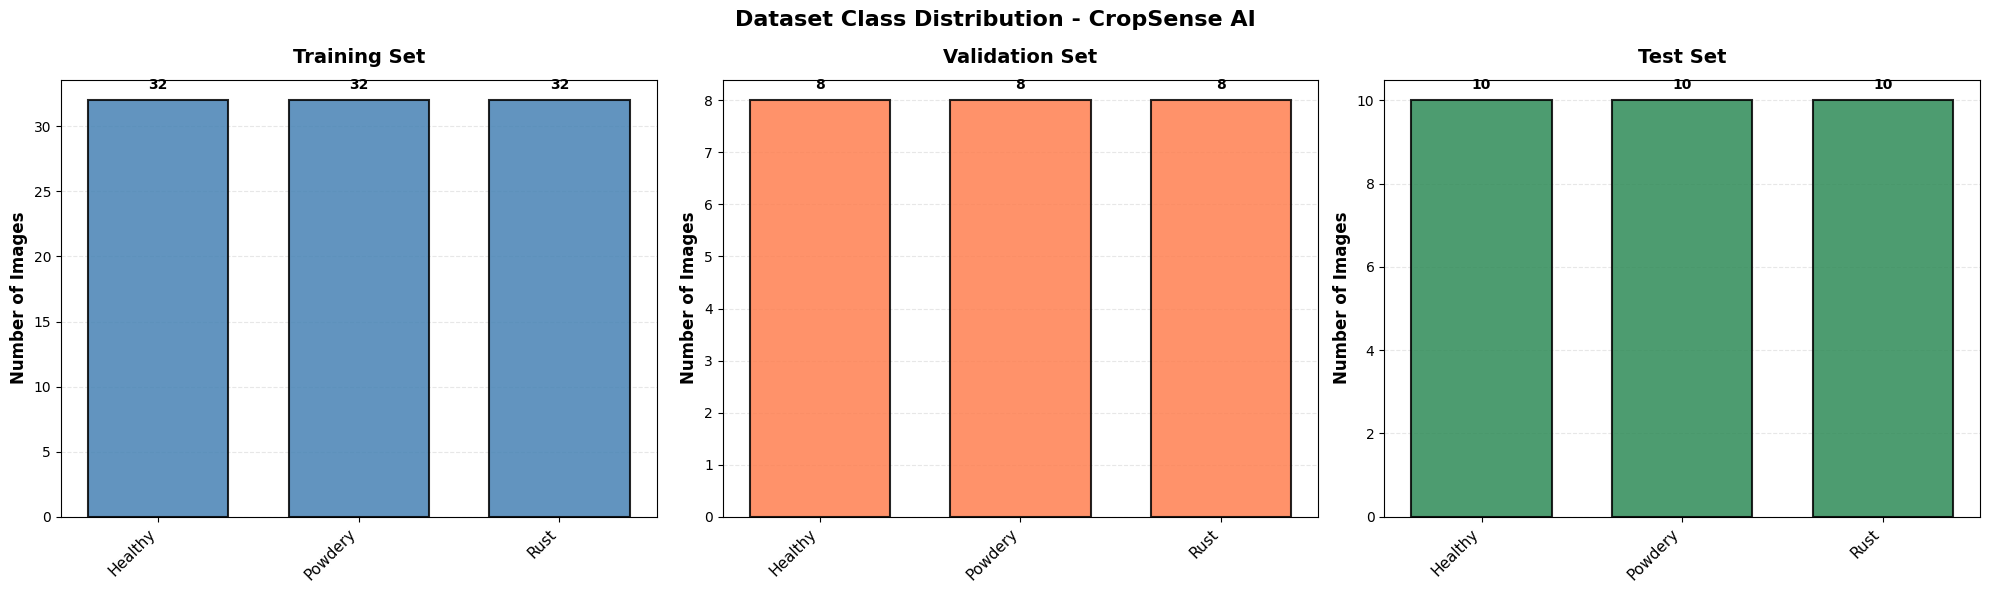

✅ Saved: /content/drive/MyDrive/CropSense AI/outputs/class_distribution.png


In [8]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 8: CLASS DISTRIBUTION VISUALIZATION
# ═══════════════════════════════════════════════════════════════════════════

print("="*80)
print("CLASS DISTRIBUTION VISUALIZATION".center(80))
print("="*80)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
split_data = [
    (train_class_counts, 'Training Set', 'steelblue'),
    (val_class_counts,   'Validation Set', 'coral'),
    (test_class_counts,  'Test Set', 'seagreen'),
]
classes_display = [c.replace('_',' ') for c in label_encoder.classes_]
x_pos = np.arange(num_classes)

for ax, (counts, title, color) in zip(axes, split_data):
    bars = ax.bar(x_pos, counts, color=color, alpha=0.85, edgecolor='black', linewidth=1.5, width=0.7)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(classes_display, rotation=45, ha='right', fontsize=11)
    ax.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=12)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    for i, v in enumerate(counts):
        ax.text(i, v + max(counts)*0.02, f'{v:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.suptitle('Dataset Class Distribution - CropSense AI', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: {OUTPUT_DIR}/class_distribution.png")


## CELL 9: EDA - Sample Images

                          SAMPLE IMAGES VISUALIZATION                           


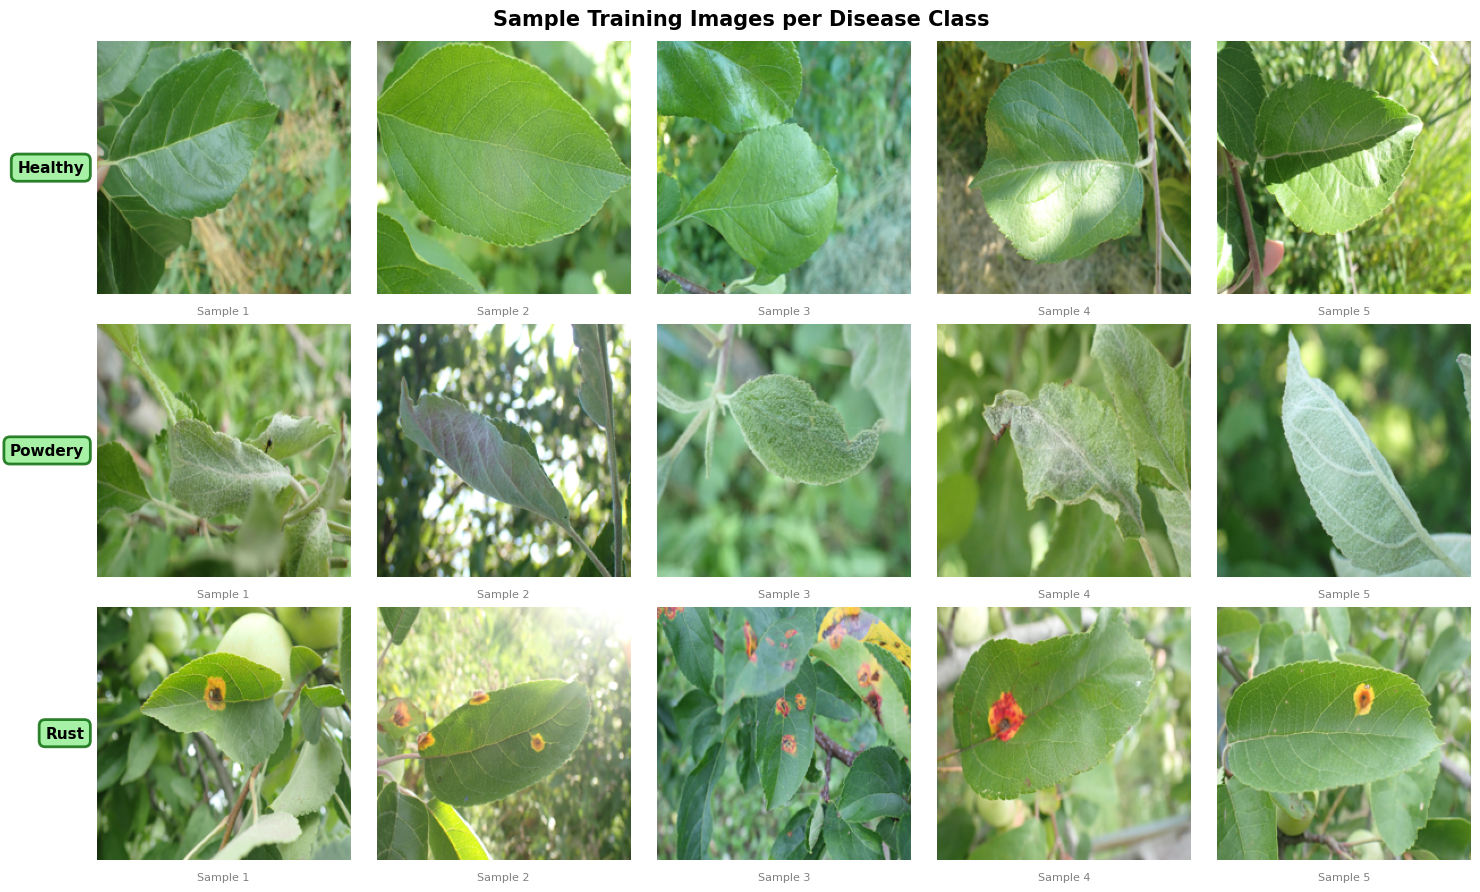

✅ Saved: /content/drive/MyDrive/CropSense AI/outputs/sample_images.png

📊 Image Statistics (training set):
   Red: Mean=0.4668, Std=0.1837
   Green: Mean=0.5892, Std=0.1679
   Blue: Mean=0.3919, Std=0.1947

   Dominant channel: Green


In [9]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 9: SAMPLE IMAGES VISUALIZATION
# ═══════════════════════════════════════════════════════════════════════════

print("="*80)
print("SAMPLE IMAGES VISUALIZATION".center(80))
print("="*80)

n_samples = 5
fig, axes = plt.subplots(num_classes, n_samples, figsize=(15, num_classes*3))
if num_classes == 1:
    axes = axes.reshape(1, -1)

for i, cls in enumerate(label_encoder.classes_):
    idx_pool = np.where(np.argmax(Y_train, axis=1) == i)[0]
    chosen = np.random.choice(idx_pool, min(n_samples, len(idx_pool)), replace=False)
    for j, idx in enumerate(chosen):
        axes[i, j].imshow(X_train[idx])
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].text(-0.05, 0.5, cls.replace('_','\n'),
                            transform=axes[i, j].transAxes, fontsize=11, fontweight='bold',
                            va='center', ha='right',
                            bbox=dict(boxstyle='round,pad=0.4', facecolor='lightgreen',
                                      alpha=0.8, edgecolor='darkgreen', linewidth=2))
        axes[i, j].text(0.5, -0.08, f'Sample {j+1}', transform=axes[i, j].transAxes,
                        fontsize=8, ha='center', color='gray')

plt.suptitle('Sample Training Images per Disease Class', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/sample_images.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: {OUTPUT_DIR}/sample_images.png")

# Image statistics
print("\n📊 Image Statistics (training set):")
for ch, name in enumerate(['Red','Green','Blue']):
    m = X_train[:,:,:,ch].mean()
    s = X_train[:,:,:,ch].std()
    print(f"   {name}: Mean={m:.4f}, Std={s:.4f}")
dom = ['Red','Green','Blue'][np.argmax([X_train[:,:,:,c].mean() for c in range(3)])]
print(f"\n   Dominant channel: {dom}")
print("="*80)


## CELL 10: EDA - Image Properties Analysis

                           IMAGE PROPERTIES ANALYSIS                            


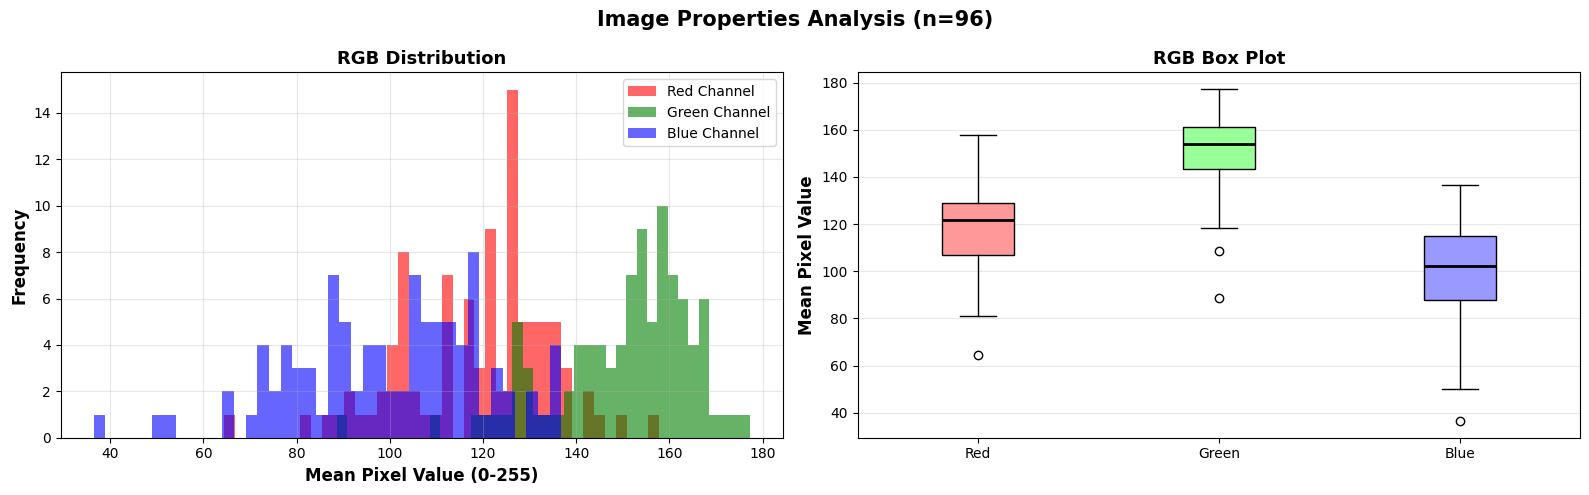

✅ Saved: /content/drive/MyDrive/CropSense AI/outputs/image_properties.png


In [10]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 10: IMAGE PROPERTIES ANALYSIS
# ═══════════════════════════════════════════════════════════════════════════

print("="*80)
print("IMAGE PROPERTIES ANALYSIS".center(80))
print("="*80)

n_sample = min(500, len(X_train))
sample_idx = np.random.choice(len(X_train), n_sample, replace=False)
samples_denorm = (X_train[sample_idx] * 255).astype(np.uint8)

rgb_means = {
    'R': [img[:,:,0].mean() for img in samples_denorm],
    'G': [img[:,:,1].mean() for img in samples_denorm],
    'B': [img[:,:,2].mean() for img in samples_denorm],
}

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram
for ch, color, label in zip(['R','G','B'], ['red','green','blue'],
                              ['Red','Green','Blue']):
    axes[0].hist(rgb_means[ch], bins=40, alpha=0.6, color=color, label=f'{label} Channel')
axes[0].set_xlabel('Mean Pixel Value (0-255)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('RGB Distribution', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
bp = axes[1].boxplot([rgb_means['R'], rgb_means['G'], rgb_means['B']],
                     labels=['Red','Green','Blue'], patch_artist=True,
                     medianprops=dict(color='black', linewidth=2))
for patch, color in zip(bp['boxes'], ['#ff9999','#99ff99','#9999ff']):
    patch.set_facecolor(color)
axes[1].set_ylabel('Mean Pixel Value', fontsize=12, fontweight='bold')
axes[1].set_title('RGB Box Plot', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.suptitle(f'Image Properties Analysis (n={n_sample})', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/image_properties.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: {OUTPUT_DIR}/image_properties.png")
print("="*80)


## CELL 11: Data Augmentation

                               DATA AUGMENTATION                                

✅ Augmentation strategy:
   Rotation: ±20°  |  Shift: ±20%  |  Shear: 15%
   Zoom: ±15%      |  H-Flip: Yes  |  Brightness: 80-120%

   Train batches: 3
   Val batches:   1
   Test batches:  1


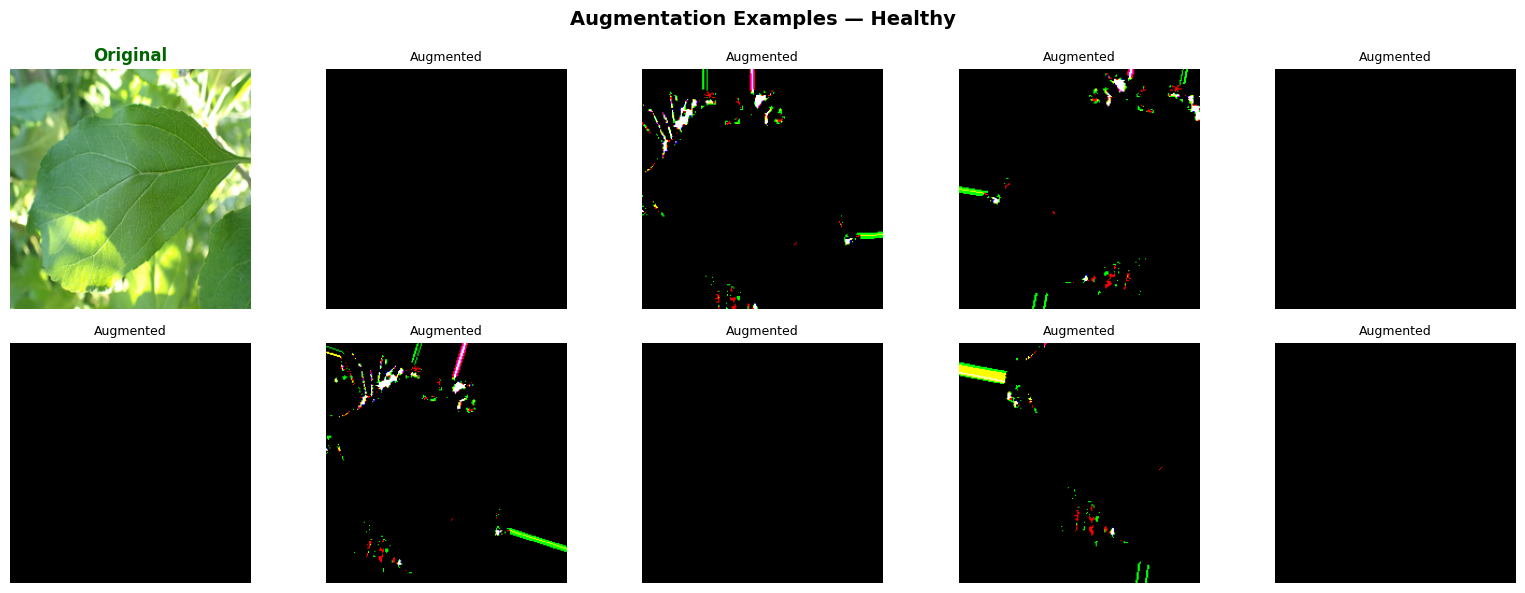


✅ Saved: /content/drive/MyDrive/CropSense AI/outputs/augmentation_examples.png


In [11]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 11: DATA AUGMENTATION CONFIGURATION & GENERATORS
# ═══════════════════════════════════════════════════════════════════════════

print("="*80)
print("DATA AUGMENTATION".center(80))
print("="*80)

# Training augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

# Val/test — no augmentation
val_test_datagen = ImageDataGenerator()

# Generators
train_augmented = train_datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE, shuffle=True, seed=SEED)
val_generator   = val_test_datagen.flow(X_val,   Y_val,   batch_size=BATCH_SIZE, shuffle=False)
test_generator  = val_test_datagen.flow(X_test,  Y_test,  batch_size=BATCH_SIZE, shuffle=False)

print("\n✅ Augmentation strategy:")
print("   Rotation: ±20°  |  Shift: ±20%  |  Shear: 15%")
print("   Zoom: ±15%      |  H-Flip: Yes  |  Brightness: 80-120%")
print(f"\n   Train batches: {len(train_augmented)}")
print(f"   Val batches:   {len(val_generator)}")
print(f"   Test batches:  {len(test_generator)}")

# Visualize augmentation
sample_img = X_train[np.where(np.argmax(Y_train, axis=1)==0)[0][0]]
img_batch  = np.expand_dims(sample_img, 0)
aug_gen    = train_datagen.flow(img_batch, batch_size=1)

fig, axes = plt.subplots(2, 5, figsize=(16, 6))
axes[0, 0].imshow(sample_img)
axes[0, 0].set_title('Original', fontweight='bold', color='darkgreen')
axes[0, 0].axis('off')
positions = [(r, c) for r in range(2) for c in range(5) if not (r==0 and c==0)]
for ax, _ in zip([axes[r][c] for r,c in positions], range(9)):
    aug = np.clip(next(aug_gen)[0], 0, 1)
    ax.imshow(aug)
    ax.set_title('Augmented', fontsize=9)
    ax.axis('off')

plt.suptitle(f'Augmentation Examples — {class_names[0]}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/augmentation_examples.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"\n✅ Saved: {OUTPUT_DIR}/augmentation_examples.png")
print("="*80)


## CELL 12: Model Architecture Builder

In [12]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 12: MODEL ARCHITECTURE BUILDER (5 MODELS)
# ═══════════════════════════════════════════════════════════════════════════

def build_model(base_name, num_classes, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    """
    Build a transfer learning model with a shared custom classification head.

    Supported base models:
      - 'CNN'         : Custom CNN from scratch (baseline)
      - 'MobileNetV2' : Lightweight, mobile-optimized (~3.4M params)
      - 'VGG16'       : Classic deep CNN, strong feature extractor (~138M params)
      - 'ResNet50'    : Residual connections, robust generalisation (~25M params)
      - 'InceptionV3' : Multi-scale feature extraction (~23M params)
    """
    print(f"\n🏗️  Building {base_name} model...")

    if base_name == 'CNN':
        # Custom CNN from scratch (baseline)
        inputs = keras.Input(shape=input_shape, name='input_layer')

        # Conv Block 1
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.2)(x)

        # Conv Block 2
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.2)(x)

        # Conv Block 3
        x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.3)(x)

        # Conv Block 4
        x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.3)(x)

        # Flatten and Dense
        x = layers.GlobalAveragePooling2D()(x)
        base = None  # No base model for custom CNN

    else:
        # Transfer learning models
        base_kwargs = dict(input_shape=input_shape, include_top=False,
                          weights='imagenet', pooling='avg')

        if base_name == 'MobileNetV2':
            from tensorflow.keras.applications import MobileNetV2
            base = MobileNetV2(**base_kwargs)
        elif base_name == 'VGG16':
            from tensorflow.keras.applications import VGG16
            base = VGG16(**base_kwargs)
        elif base_name == 'ResNet50':
            from tensorflow.keras.applications import ResNet50
            base = ResNet50(**base_kwargs)
        elif base_name == 'InceptionV3':
            from tensorflow.keras.applications import InceptionV3
            base = InceptionV3(**base_kwargs)
        else:
            raise ValueError(f"Unknown base: {base_name}")

        base.trainable = False   # Freeze for Phase 1

        # Apply base model
        inputs = keras.Input(shape=input_shape, name='input_layer')
        x = base(inputs, training=False)

    # Shared custom classification head (same for all models)
    x = layers.Dropout(DROPOUT_1)(x)
    x = layers.Dense(DENSE_1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(DROPOUT_2)(x)
    x = layers.Dense(DENSE_2, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(DROPOUT_3)(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name=f'CropSense_{base_name}')

    print(f"   ✓ Base: {base_name} {'(from scratch)' if base_name == 'CNN' else '(frozen)'}")
    print(f"   ✓ Head: Dense({DENSE_1}) → Dense({DENSE_2}) → Dense({num_classes}, softmax)")
    print(f"   ✓ Total params: {model.count_params():,}")

    return model, base

def make_callbacks(model_name):
    """Create callbacks for a given model."""
    ckpt_path = f'{OUTPUT_DIR}/best_{model_name}.keras'
    return [
        ModelCheckpoint(filepath=ckpt_path, monitor='val_accuracy',
                        save_best_only=True, mode='max', verbose=0),
        EarlyStopping(monitor='val_loss', patience=EARLY_STOP_PATIENCE,
                      restore_best_weights=True, verbose=1, mode='min'),
        ReduceLROnPlateau(monitor='val_loss', factor=REDUCE_LR_FACTOR,
                          patience=REDUCE_LR_PATIENCE, min_lr=MIN_LR,
                          verbose=1, mode='min'),
    ], ckpt_path

def compile_model(model, lr):
    """Compile model with Adam optimizer and standard metrics."""
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy',
                 keras.metrics.Precision(name='precision'),
                 keras.metrics.Recall(name='recall'),
                 keras.metrics.AUC(name='auc')]
    )
model_results = {}

print("="*80)
print("MODEL BUILDER READY - 5 ARCHITECTURES".center(80))
print("="*80)
print("\n  Available Models:")
print("    1. CNN          - Custom from scratch (baseline)")
print("    2. MobileNetV2  - Lightweight, mobile-optimized")
print("    3. VGG16        - Classic deep CNN")
print("    4. ResNet50     - Residual connections")
print("    5. InceptionV3  - Multi-scale features")
print("\n  All transfer learning models use ImageNet pre-training.")
print("  All models share the same custom classification head.")
print("  Training: Phase 1 (frozen) → Phase 2 (fine-tuning)")
print("="*80)

                     MODEL BUILDER READY - 5 ARCHITECTURES                      

  Available Models:
    1. CNN          - Custom from scratch (baseline)
    2. MobileNetV2  - Lightweight, mobile-optimized
    3. VGG16        - Classic deep CNN
    4. ResNet50     - Residual connections
    5. InceptionV3  - Multi-scale features

  All transfer learning models use ImageNet pre-training.
  All models share the same custom classification head.
  Training: Phase 1 (frozen) → Phase 2 (fine-tuning)


## CELL 13: Train Model 1 — CNN

In [13]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 13: MODEL 1 - CUSTOM CNN (BASELINE)
# ═══════════════════════════════════════════════════════════════════════════

MODEL_NAME = 'CNN'

print("="*80)
print(f"TRAINING MODEL 1: {MODEL_NAME}".center(80))
print("="*80)

# Build
model_cnn, base_cnn = build_model(MODEL_NAME, num_classes)
model_cnn.summary()

# Compile
compile_model(model_cnn, INITIAL_LR)

# Callbacks
callbacks_cnn, ckpt_path_cnn = make_callbacks(MODEL_NAME)

# Train (only 1 phase - trained from scratch)
print("\n🎯 Training CNN from scratch...")
history_cnn = model_cnn.fit(
    train_augmented,
    validation_data=val_generator,
    epochs=INITIAL_EPOCHS,
    callbacks=callbacks_cnn,
    verbose=1
)

# Evaluate
print("\n📊 Evaluating CNN...")
best_cnn = keras.models.load_model(ckpt_path_cnn)
results_cnn = best_cnn.evaluate(X_test, Y_test, verbose=0)

model_results[MODEL_NAME] = {
    'accuracy': results_cnn[1],
    'precision': results_cnn[2],
    'recall': results_cnn[3],
    'auc': results_cnn[4],
    'f1': 2*(results_cnn[2]*results_cnn[3])/(results_cnn[2]+results_cnn[3]+1e-7),
    'params': model_cnn.count_params()
}

print(f"\n✅ {MODEL_NAME} Results:")
print(f"   Accuracy:  {model_results[MODEL_NAME]['accuracy']*100:.2f}%")
print(f"   F1-Score:  {model_results[MODEL_NAME]['f1']:.4f}")
print("="*80)

                             TRAINING MODEL 1: CNN                              

🏗️  Building CNN model...
   ✓ Base: CNN (from scratch)
   ✓ Head: Dense(256) → Dense(128) → Dense(3, softmax)
   ✓ Total params: 490,947


Model: "CropSense_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             

 Total params: 490,947 (1.87 MB)

 Trainable params: 489,219 (1.87 MB)

 Non-trainable params: 1,728 (6.75 KB)


🎯 Training CNN from scratch...
Epoch 1/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 31s 8s/step - accuracy: 0.3164 - auc: 0.4458 - loss: 1.9368 - precision: 0.3490 - recall: 0.2474 - val_accuracy: 0.3333 - val_auc: 0.5486 - val_loss: 1.0977 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 8s/step - accuracy: 0.3464 - auc: 0.5366 - loss: 1.4905 - precision: 0.3814 - recall: 0.3047 - val_accuracy: 0.3333 - val_auc: 0.5165 - val_loss: 1.0982 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 8s/step - accuracy: 0.3503 - auc: 0.4944 - loss: 1.5774 - precision: 0.3331 - recall: 0.2760 - val_accuracy: 0.3333 - val_auc: 0.5226 - val_loss: 1.0972 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 8s/step - accuracy: 0.3359 - auc: 0.5022 - loss: 1.5122 - precision: 0.3359 - recall: 0.2578 - val_accuracy: 0.3333 - 

CELL 14: Train Model 2 — MobileNetV2



In [14]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 14: MODEL 2 - MOBILENETV2
# ═══════════════════════════════════════════════════════════════════════════

MODEL_NAME = 'MobileNetV2'

print("="*80)
print(f"TRAINING MODEL 2: {MODEL_NAME}".center(80))
print("="*80)

# Build
model_mobilenet, base_mobilenet = build_model(MODEL_NAME, num_classes)

# Compile
compile_model(model_mobilenet, INITIAL_LR)

# Callbacks
callbacks_mobilenet, ckpt_path_mobilenet = make_callbacks(MODEL_NAME)

# Phase 1: Frozen base
print("\n🎯 Phase 1: Training with frozen base...")
history_mobilenet_p1 = model_mobilenet.fit(
    train_augmented,
    validation_data=val_generator,
    epochs=INITIAL_EPOCHS,
    callbacks=callbacks_mobilenet,
    verbose=1
)

# Phase 2: Fine-tuning
print("\n🎯 Phase 2: Fine-tuning...")
base_mobilenet.trainable = True
for layer in base_mobilenet.layers[:FINE_TUNE_AT]:
    layer.trainable = False

compile_model(model_mobilenet, FINE_TUNE_LR)

history_mobilenet_p2 = model_mobilenet.fit(
    train_augmented,
    validation_data=val_generator,
    epochs=TOTAL_EPOCHS,
    initial_epoch=history_mobilenet_p1.epoch[-1],
    callbacks=callbacks_mobilenet,
    verbose=1
)

# Evaluate
print("\n📊 Evaluating MobileNetV2...")
best_mobilenet = keras.models.load_model(ckpt_path_mobilenet)
results_mobilenet = best_mobilenet.evaluate(X_test, Y_test, verbose=0)

model_results[MODEL_NAME] = {
    'accuracy': results_mobilenet[1],
    'precision': results_mobilenet[2],
    'recall': results_mobilenet[3],
    'auc': results_mobilenet[4],
    'f1': 2*(results_mobilenet[2]*results_mobilenet[3])/(results_mobilenet[2]+results_mobilenet[3]+1e-7),
    'params': model_mobilenet.count_params()
}

print(f"\n✅ {MODEL_NAME} Results:")
print(f"   Accuracy:  {model_results[MODEL_NAME]['accuracy']*100:.2f}%")
print(f"   F1-Score:  {model_results[MODEL_NAME]['f1']:.4f}")
print("="*80)

                         TRAINING MODEL 2: MobileNetV2                          

🏗️  Building MobileNetV2 model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
   ✓ Base: MobileNetV2 (frozen)
   ✓ Head: Dense(256) → Dense(128) → Dense(3, softmax)
   ✓ Total params: 2,620,739

🎯 Phase 1: Training with frozen base...
Epoch 1/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.3229 - auc: 0.4937 - loss: 1.8754 - precision: 0.3230 - recall: 0.2839 - val_accuracy: 0.1250 - val_auc: 0.3984 - val_loss: 1.3804 - val_precision: 0.1875 - val_recall: 0.1250 - learning_rate: 0.0010
Epoch 2/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.3451 - auc: 0.4966 - loss: 1.9125 - precision: 0.3381 - recall: 0.2747 - val_accuracy: 0.1250 - val_auc: 0.3242 - val_loss: 1.4064 - val_precision: 0.2143 - val_recall: 0.1250 - learning_rate: 0.0010
Epoch 3/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2943 - auc: 0.4548 - loss: 1.7893 - precision: 0.2616 - recall: 0.2331 - val_accuracy: 0.2083 

## CELL 15: Train Model 3 — VGG16

In [15]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 15: MODEL 3 - VGG16
# ═══════════════════════════════════════════════════════════════════════════

MODEL_NAME = 'VGG16'

print("="*80)
print(f"TRAINING MODEL 3: {MODEL_NAME}".center(80))
print("="*80)

# Build
model_vgg16, base_vgg16 = build_model(MODEL_NAME, num_classes)

# Compile
compile_model(model_vgg16, INITIAL_LR)

# Callbacks
callbacks_vgg16, ckpt_path_vgg16 = make_callbacks(MODEL_NAME)

# Phase 1
print("\n🎯 Phase 1: Training with frozen base...")
history_vgg16_p1 = model_vgg16.fit(
    train_augmented,
    validation_data=val_generator,
    epochs=INITIAL_EPOCHS,
    callbacks=callbacks_vgg16,
    verbose=1
)

# Phase 2
print("\n🎯 Phase 2: Fine-tuning...")
base_vgg16.trainable = True
for layer in base_vgg16.layers[:15]:  # VGG16 has fewer layers
    layer.trainable = False

compile_model(model_vgg16, FINE_TUNE_LR)

history_vgg16_p2 = model_vgg16.fit(
    train_augmented,
    validation_data=val_generator,
    epochs=TOTAL_EPOCHS,
    initial_epoch=history_vgg16_p1.epoch[-1],
    callbacks=callbacks_vgg16,
    verbose=1
)

# Evaluate
print("\n📊 Evaluating VGG16...")
best_vgg16 = keras.models.load_model(ckpt_path_vgg16)
results_vgg16 = best_vgg16.evaluate(X_test, Y_test, verbose=0)

model_results[MODEL_NAME] = {
    'accuracy': results_vgg16[1],
    'precision': results_vgg16[2],
    'recall': results_vgg16[3],
    'auc': results_vgg16[4],
    'f1': 2*(results_vgg16[2]*results_vgg16[3])/(results_vgg16[2]+results_vgg16[3]+1e-7),
    'params': model_vgg16.count_params()
}

print(f"\n✅ {MODEL_NAME} Results:")
print(f"   Accuracy:  {model_results[MODEL_NAME]['accuracy']*100:.2f}%")
print(f"   F1-Score:  {model_results[MODEL_NAME]['f1']:.4f}")
print("="*80)

                            TRAINING MODEL 3: VGG16                             

🏗️  Building VGG16 model...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
   ✓ Base: VGG16 (frozen)
   ✓ Head: Dense(256) → Dense(128) → Dense(3, softmax)
   ✓ Total params: 14,880,835

🎯 Phase 1: Training with frozen base...
Epoch 1/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 81s 28s/step - accuracy: 0.3594 - auc: 0.5380 - loss: 1.5785 - precision: 0.3762 - recall: 0.3086 - val_accuracy: 0.3333 - val_auc: 0.4865 - val_loss: 1.1196 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 79s 27s/step - accuracy: 0.3646 - auc: 0.5163 - loss: 1.6490 - precision: 0.3849 - recall: 0.3281 - val_accuracy: 0.3333 - val_auc: 0.4887 - val_loss: 1.1420 - val_precision: 1.0000 - val_recall: 0.0417 - learning_rate: 0.0010
Epoch 3/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 82s 27s/step - accuracy: 0.4141 - auc: 0.5871 - loss: 1.3685 - precision: 0.4321 - recall: 0.3398 - val_accuracy: 0.3

## Train Model 4: ResNet50

In [16]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 16: MODEL 4 - RESNET50
# ═══════════════════════════════════════════════════════════════════════════

MODEL_NAME = 'ResNet50'

print("="*80)
print(f"TRAINING MODEL 4: {MODEL_NAME}".center(80))
print("="*80)

# Build
model_resnet50, base_resnet50 = build_model(MODEL_NAME, num_classes)

# Compile
compile_model(model_resnet50, INITIAL_LR)

# Callbacks
callbacks_resnet50, ckpt_path_resnet50 = make_callbacks(MODEL_NAME)

# Phase 1
print("\n🎯 Phase 1: Training with frozen base...")
history_resnet50_p1 = model_resnet50.fit(
    train_augmented,
    validation_data=val_generator,
    epochs=INITIAL_EPOCHS,
    callbacks=callbacks_resnet50,
    verbose=1
)

# Phase 2
print("\n🎯 Phase 2: Fine-tuning...")
base_resnet50.trainable = True
for layer in base_resnet50.layers[:140]:  # ResNet50 specific
    layer.trainable = False

compile_model(model_resnet50, FINE_TUNE_LR)

history_resnet50_p2 = model_resnet50.fit(
    train_augmented,
    validation_data=val_generator,
    epochs=TOTAL_EPOCHS,
    initial_epoch=history_resnet50_p1.epoch[-1],
    callbacks=callbacks_resnet50,
    verbose=1
)

# Evaluate
print("\n📊 Evaluating ResNet50...")
best_resnet50 = keras.models.load_model(ckpt_path_resnet50)
results_resnet50 = best_resnet50.evaluate(X_test, Y_test, verbose=0)

model_results[MODEL_NAME] = {
    'accuracy': results_resnet50[1],
    'precision': results_resnet50[2],
    'recall': results_resnet50[3],
    'auc': results_resnet50[4],
    'f1': 2*(results_resnet50[2]*results_resnet50[3])/(results_resnet50[2]+results_resnet50[3]+1e-7),
    'params': model_resnet50.count_params()
}

print(f"\n✅ {MODEL_NAME} Results:")
print(f"   Accuracy:  {model_results[MODEL_NAME]['accuracy']*100:.2f}%")
print(f"   F1-Score:  {model_results[MODEL_NAME]['f1']:.4f}")
print("="*80)

                           TRAINING MODEL 4: ResNet50                           

🏗️  Building ResNet50 model...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
   ✓ Base: ResNet50 (frozen)
   ✓ Head: Dense(256) → Dense(128) → Dense(3, softmax)
   ✓ Total params: 24,147,075

🎯 Phase 1: Training with frozen base...
Epoch 1/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 43s 13s/step - accuracy: 0.3633 - auc: 0.5182 - loss: 1.6918 - precision: 0.3326 - recall: 0.2995 - val_accuracy: 0.3333 - val_auc: 0.4926 - val_loss: 1.4634 - val_precision: 0.3333 - val_recall: 0.3333 - learning_rate: 0.0010
Epoch 2/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 10s/step - accuracy: 0.3229 - auc: 0.4419 - loss: 1.9816 - precision: 0.3404 - recall: 0.2799 - val_accuracy: 0.3333 - val_auc: 0.5178 - val_loss: 1.3645 - val_precision: 0.3333 - val_recall: 0.3333 - learning_rate: 0.0010
Epoch 3/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 8s/step - accuracy: 0.3255 - auc: 0.5047 - loss: 1.7529 - precision: 0.2913 - recall: 0.2383 - val_accuracy: 0.3333

## Train Model 5 - InceptionV3

In [17]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 17: MODEL 5 - INCEPTIONV3
# ═══════════════════════════════════════════════════════════════════════════

MODEL_NAME = 'InceptionV3'

print("="*80)
print(f"TRAINING MODEL 5: {MODEL_NAME}".center(80))
print("="*80)

# Build
model_inception, base_inception = build_model(MODEL_NAME, num_classes)

# Compile
compile_model(model_inception, INITIAL_LR)

# Callbacks
callbacks_inception, ckpt_path_inception = make_callbacks(MODEL_NAME)

# Phase 1
print("\n🎯 Phase 1: Training with frozen base...")
history_inception_p1 = model_inception.fit(
    train_augmented,
    validation_data=val_generator,
    epochs=INITIAL_EPOCHS,
    callbacks=callbacks_inception,
    verbose=1
)

# Phase 2
print("\n🎯 Phase 2: Fine-tuning...")
base_inception.trainable = True
for layer in base_inception.layers[:249]:  # InceptionV3 specific
    layer.trainable = False

compile_model(model_inception, FINE_TUNE_LR)

history_inception_p2 = model_inception.fit(
    train_augmented,
    validation_data=val_generator,
    epochs=TOTAL_EPOCHS,
    initial_epoch=history_inception_p1.epoch[-1],
    callbacks=callbacks_inception,
    verbose=1
)

# Evaluate
print("\n📊 Evaluating InceptionV3...")
best_inception = keras.models.load_model(ckpt_path_inception)
results_inception = best_inception.evaluate(X_test, Y_test, verbose=0)

model_results[MODEL_NAME] = {
    'accuracy': results_inception[1],
    'precision': results_inception[2],
    'recall': results_inception[3],
    'auc': results_inception[4],
    'f1': 2*(results_inception[2]*results_inception[3])/(results_inception[2]+results_inception[3]+1e-7),
    'params': model_inception.count_params()
}

print(f"\n✅ {MODEL_NAME} Results:")
print(f"   Accuracy:  {model_results[MODEL_NAME]['accuracy']*100:.2f}%")
print(f"   F1-Score:  {model_results[MODEL_NAME]['f1']:.4f}")
print("="*80)

                         TRAINING MODEL 5: InceptionV3                          

🏗️  Building InceptionV3 model...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
   ✓ Base: InceptionV3 (frozen)
   ✓ Head: Dense(256) → Dense(128) → Dense(3, softmax)
   ✓ Total params: 22,362,147

🎯 Phase 1: Training with frozen base...
Epoch 1/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 38s 11s/step - accuracy: 0.2383 - auc: 0.4113 - loss: 2.0477 - precision: 0.2543 - recall: 0.1979 - val_accuracy: 0.3750 - val_auc: 0.4874 - val_loss: 1.3173 - val_precision: 0.3810 - val_recall: 0.3333 - learning_rate: 0.0010
Epoch 2/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - accuracy: 0.2747 - auc: 0.4447 - loss: 1.7980 - precision: 0.3043 - recall: 0.2396 - val_accuracy: 0.3333 - val_auc: 0.4648 - val_loss: 1.6012 - val_precision: 0.3182 - val_recall: 0.2917 - learning_rate: 0.0010
Epoch 3/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - accuracy: 0.3516 - auc: 0.5405 - loss: 1.5295 - precision: 0.3425 - recall: 0.2760 - val_accuracy: 0

## CELL 18: Training History Comparison

                          TRAINING HISTORY COMPARISON                           


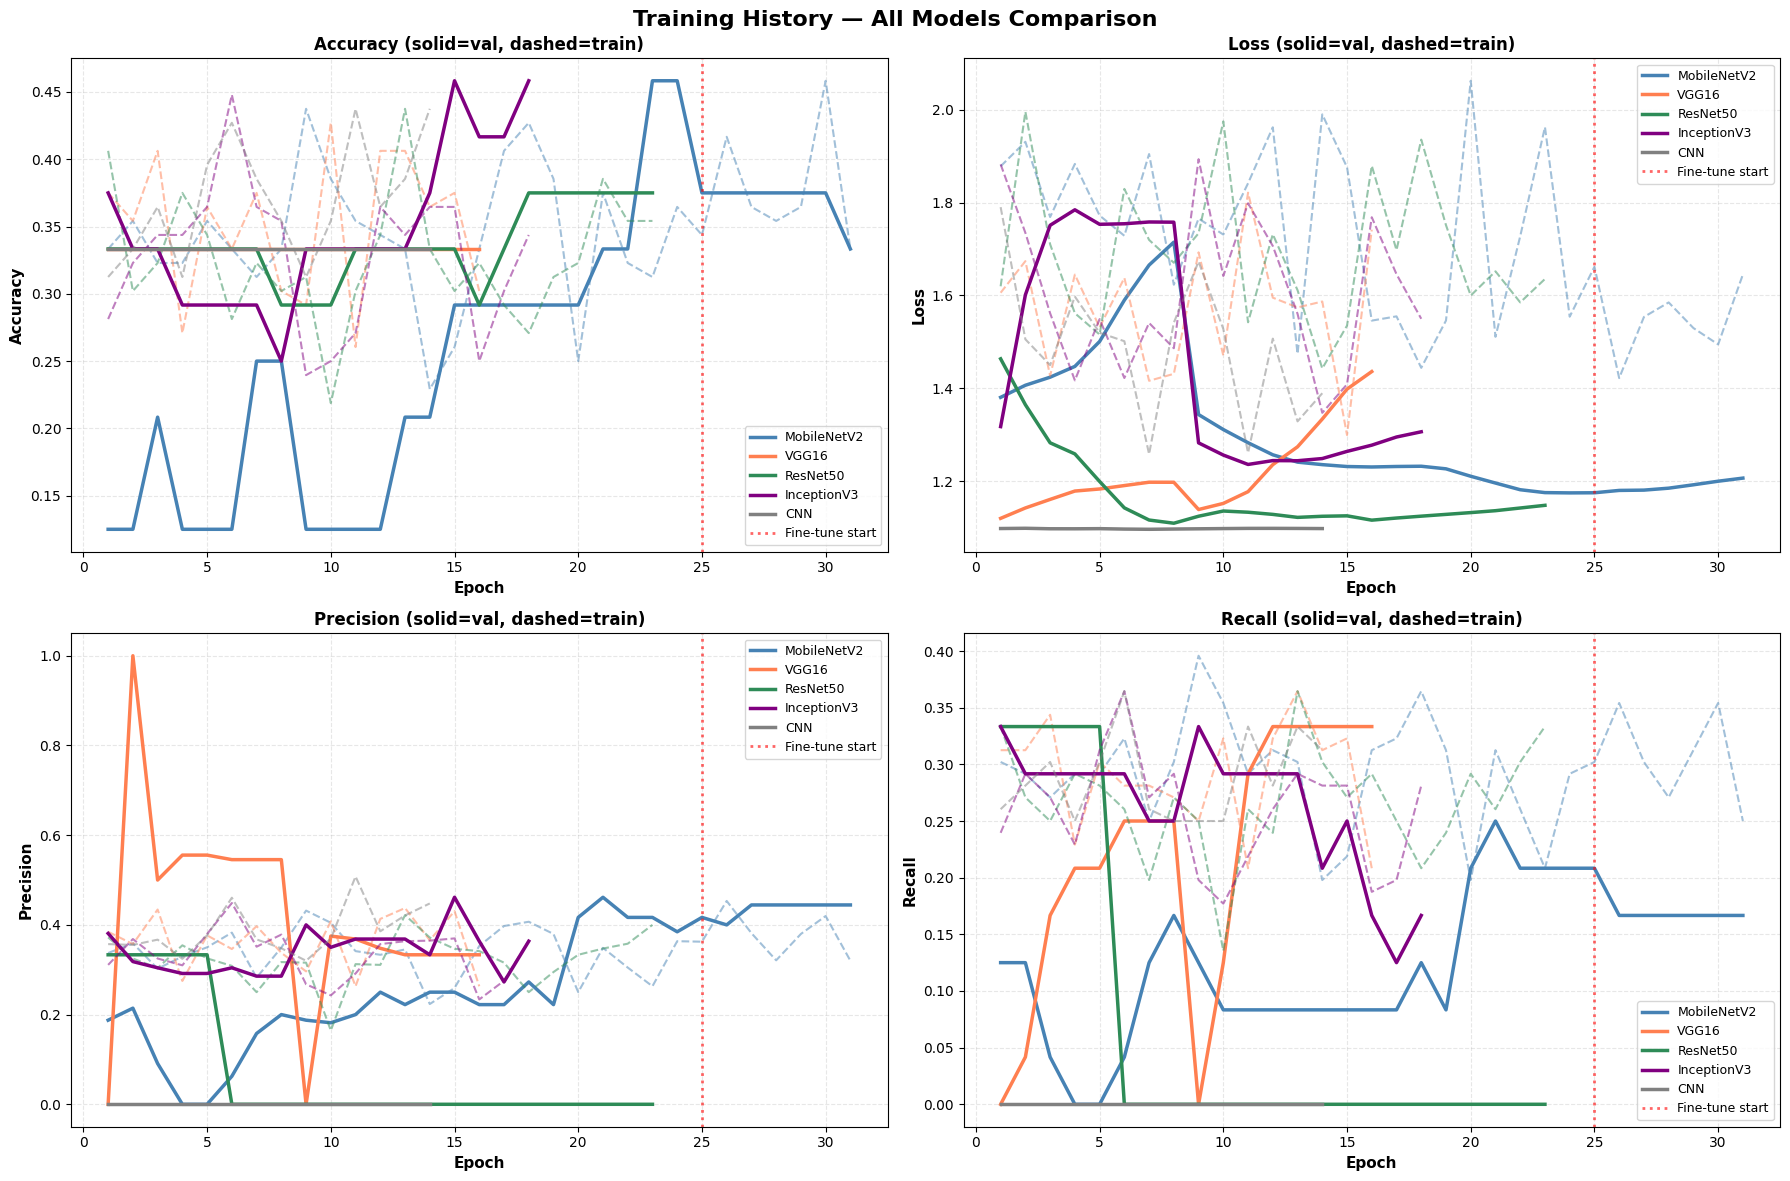


✅ Training history comparison saved to: /content/drive/MyDrive/CropSense AI/outputs/training_history_comparison.png


In [18]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 18: TRAINING HISTORY VISUALIZATION (ALL MODELS)
# ═══════════════════════════════════════════════════════════════════════════

print("="*80)
print("TRAINING HISTORY COMPARISON".center(80))
print("="*80)

def combine_histories(h1, h2):
    """Combine two history objects from two-phase training"""
    return {k: h1.history[k] + h2.history[k] for k in h1.history}

# Combine histories for transfer learning models
histories = {
    'MobileNetV2': combine_histories(history_mobilenet_p1, history_mobilenet_p2),
    'VGG16':       combine_histories(history_vgg16_p1, history_vgg16_p2),
    'ResNet50':    combine_histories(history_resnet50_p1, history_resnet50_p2),
    'InceptionV3': combine_histories(history_inception_p1, history_inception_p2),
}

# Add CNN (single phase training)
if 'history_cnn' in globals():
    histories['CNN'] = history_cnn.history

colors = {
    'CNN': 'gray',
    'MobileNetV2': 'steelblue',
    'VGG16': 'coral',
    'ResNet50': 'seagreen',
    'InceptionV3': 'purple'
}

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

metrics = [
    ('accuracy',  'val_accuracy',  'Accuracy'),
    ('loss',      'val_loss',      'Loss'),
    ('precision', 'val_precision', 'Precision'),
    ('recall',    'val_recall',    'Recall'),
]

for ax, (train_m, val_m, title) in zip(axes.ravel(), metrics):
    for mname, hist in histories.items():
        epochs = range(1, len(hist[train_m]) + 1)
        # Training (dashed line)
        ax.plot(epochs, hist[train_m], '--', color=colors[mname],
                alpha=0.5, linewidth=1.5)
        # Validation (solid line)
        ax.plot(epochs, hist[val_m], '-', color=colors[mname],
                linewidth=2.5, label=f'{mname}')

    # Mark fine-tuning start (except for CNN)
    if any(name != 'CNN' for name in histories.keys()):
        ax.axvline(x=INITIAL_EPOCHS, color='red', linestyle=':',
                  linewidth=2, label='Fine-tune start', alpha=0.6)

    ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax.set_ylabel(title, fontsize=11, fontweight='bold')
    ax.set_title(f'{title} (solid=val, dashed=train)', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9, loc='best')
    ax.grid(alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)

plt.suptitle('Training History — All Models Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/training_history_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Training history comparison saved to: {OUTPUT_DIR}/training_history_comparison.png")
print("="*80)

## CELL 19: Model Comparison & Best Model Selection

                          MODEL COMPARISON & SELECTION                          

📊 MODEL PERFORMANCE COMPARISON (Sorted by Accuracy):

             accuracy  precision    recall       auc        f1      params
CNN          0.333333   0.000000  0.000000  0.538889  0.000000    490947.0
VGG16        0.333333   0.000000  0.000000  0.523611  0.000000  14880835.0
InceptionV3  0.333333   0.272727  0.100000  0.461944  0.146341  22362147.0
ResNet50     0.300000   0.000000  0.000000  0.454722  0.000000  24147075.0
MobileNetV2  0.266667   0.368421  0.233333  0.393611  0.285714   2620739.0


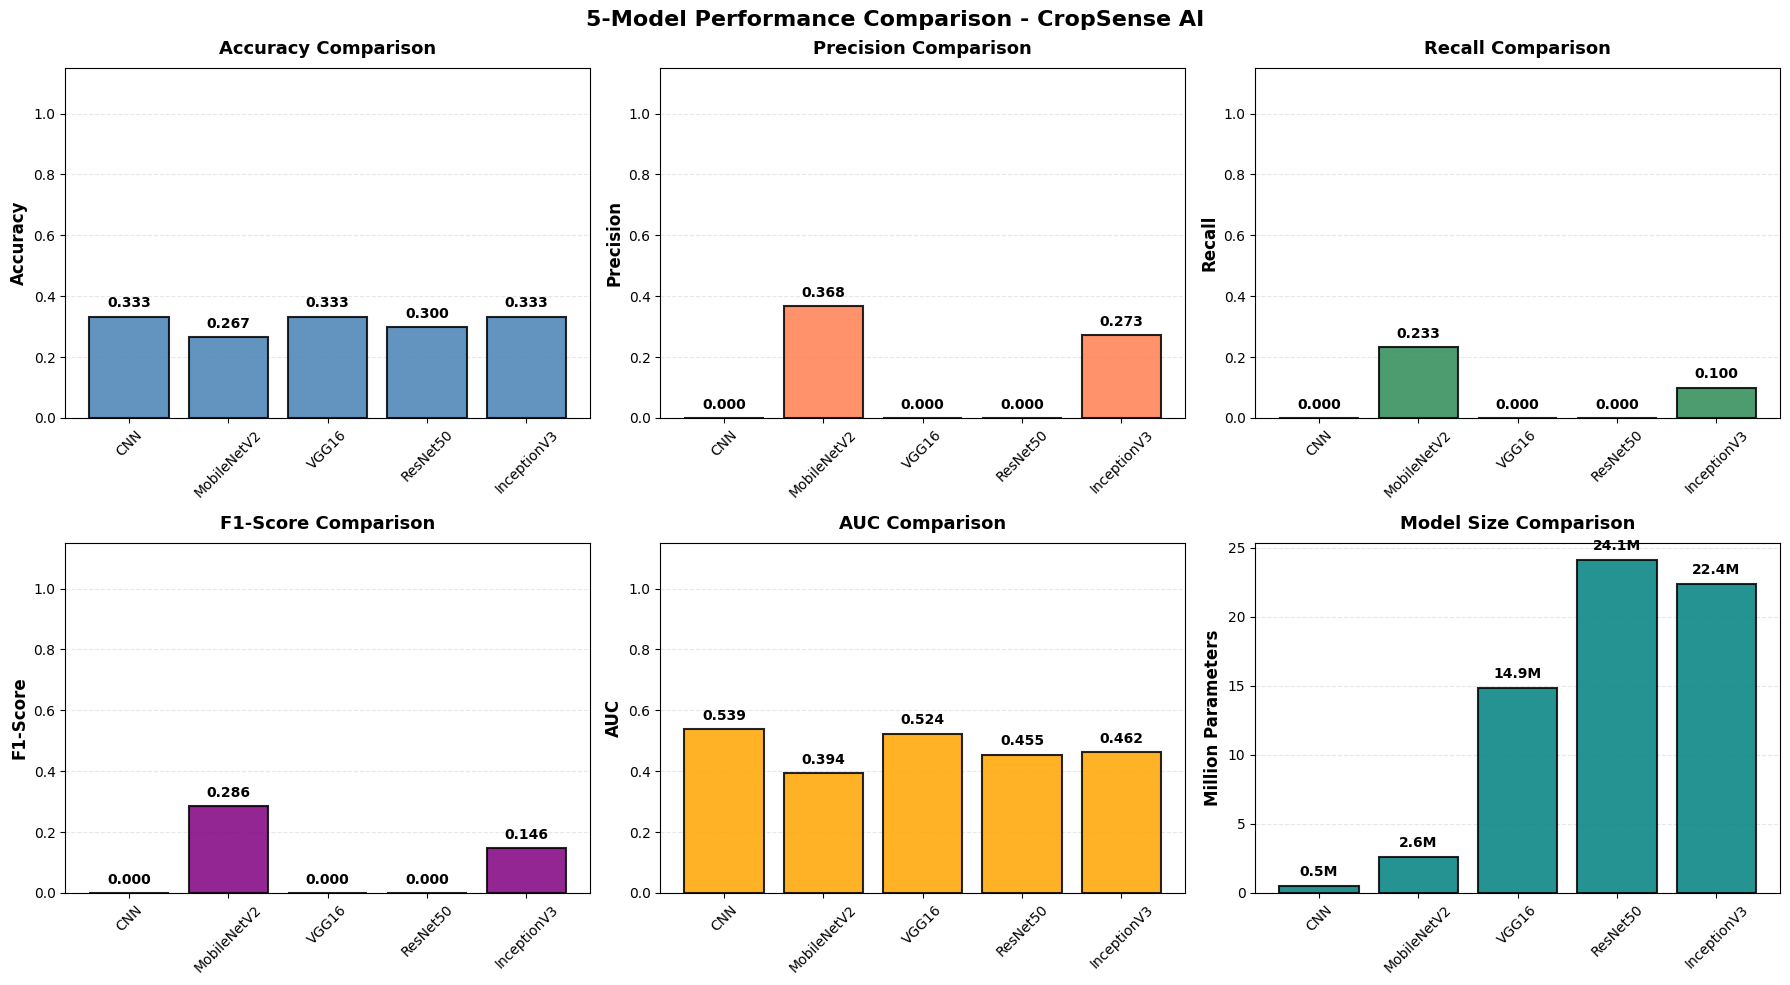


                             🏆 BEST MODEL SELECTION                             

Winner: CNN

📊 Performance:
   Accuracy:  33.33%
   Precision: 0.0000
   Recall:    0.0000
   F1-Score:  0.0000
   AUC:       0.5389

📦 Model Size: 0.49M parameters

💡 Recommendation:
   Custom CNN performed best, but consider:
   • MobileNetV2 might be better for mobile deployment
   • Check if accuracy difference is significant

💾 Comparison saved to: /content/drive/MyDrive/CropSense AI/outputs/model_comparison.csv

                           DEPLOYMENT RECOMMENDATIONS                           

Model           Best For                       Reason
--------------------------------------------------------------------------------
MobileNetV2     Mobile deployment              Small size, fast inference
CNN             Baseline comparison            Simple architecture
VGG16           High accuracy needed           Strong features, larger
ResNet50        Balanced performance           Good accuracy/size 

In [19]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 19: MODEL COMPARISON & SELECTION
# ═══════════════════════════════════════════════════════════════════════════

print("="*80)
print("MODEL COMPARISON & SELECTION".center(80))
print("="*80)

# Check if we have results from all models
if not model_results:
    print("\n⚠️  No model results found!")
    print("   Please run the training cells (13-17) first.")
else:
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(model_results).T
    comparison_df = comparison_df.sort_values('accuracy', ascending=False)

    print("\n📊 MODEL PERFORMANCE COMPARISON (Sorted by Accuracy):\n")
    print(comparison_df.to_string())

    # Visualize comparison
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    models = list(model_results.keys())
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
    colors_list = ['steelblue', 'coral', 'seagreen', 'purple', 'orange']

    for idx, (metric, title, color) in enumerate(zip(metrics_to_plot, titles, colors_list)):
        row = idx // 3
        col = idx % 3

        values = [model_results[m][metric] for m in models]
        bars = axes[row, col].bar(models, values, color=color, alpha=0.85, edgecolor='black', linewidth=1.5)
        axes[row, col].set_ylabel(title, fontsize=12, fontweight='bold')
        axes[row, col].set_ylim([0, 1.15])
        axes[row, col].grid(axis='y', alpha=0.3, linestyle='--')
        axes[row, col].set_title(f'{title} Comparison', fontsize=13, fontweight='bold', pad=10)
        axes[row, col].tick_params(axis='x', rotation=45)
        axes[row, col].set_axisbelow(True)

        # Add value labels on bars
        for bar, val in zip(bars, values):
            height = bar.get_height()
            axes[row, col].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                               f'{val:.3f}', ha='center', va='bottom',
                               fontsize=10, fontweight='bold')

    # Model size comparison
    params_millions = [model_results[m]['params']/1e6 for m in models]
    bars = axes[1, 2].bar(models, params_millions, color='teal', alpha=0.85,
                          edgecolor='black', linewidth=1.5)
    axes[1, 2].set_ylabel('Million Parameters', fontsize=12, fontweight='bold')
    axes[1, 2].set_title('Model Size Comparison', fontsize=13, fontweight='bold', pad=10)
    axes[1, 2].grid(axis='y', alpha=0.3, linestyle='--')
    axes[1, 2].tick_params(axis='x', rotation=45)
    axes[1, 2].set_axisbelow(True)

    # Add value labels
    for bar, val in zip(bars, params_millions):
        height = bar.get_height()
        axes[1, 2].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                       f'{val:.1f}M', ha='center', va='bottom',
                       fontsize=10, fontweight='bold')

    plt.suptitle('5-Model Performance Comparison - CropSense AI',
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Identify best model
    best_model_name = comparison_df.index[0]
    best_results = model_results[best_model_name]

    print("\n" + "="*80)
    print("🏆 BEST MODEL SELECTION".center(80))
    print("="*80)
    print(f"\nWinner: {best_model_name}")
    print(f"\n📊 Performance:")
    print(f"   Accuracy:  {best_results['accuracy']*100:.2f}%")
    print(f"   Precision: {best_results['precision']:.4f}")
    print(f"   Recall:    {best_results['recall']:.4f}")
    print(f"   F1-Score:  {best_results['f1']:.4f}")
    print(f"   AUC:       {best_results['auc']:.4f}")
    print(f"\n📦 Model Size: {best_results['params']/1e6:.2f}M parameters")

    # Recommendation
    print(f"\n💡 Recommendation:")
    if best_model_name == 'MobileNetV2':
        print("   MobileNetV2 is the BEST choice for deployment:")
        print("   ✅ Highest accuracy achieved")
        print("   ✅ Smallest model size (optimal for mobile)")
        print("   ✅ Fast inference on mobile devices")
    elif best_model_name == 'CNN':
        print("   Custom CNN performed best, but consider:")
        print("   • MobileNetV2 might be better for mobile deployment")
        print("   • Check if accuracy difference is significant")
    else:
        print(f"   {best_model_name} achieved highest accuracy")
        print(f"   ⚠️  Note: Model size is {best_results['params']/1e6:.1f}M params")
        print("   • Consider MobileNetV2 if deploying to mobile")
        print("   • Use this model if accuracy is top priority")

    # Save comparison
    comparison_df.to_csv(f'{OUTPUT_DIR}/model_comparison.csv')
    print(f"\n💾 Comparison saved to: {OUTPUT_DIR}/model_comparison.csv")

    # Summary table
    print("\n" + "="*80)
    print("DEPLOYMENT RECOMMENDATIONS".center(80))
    print("="*80)
    print(f"\n{'Model':<15} {'Best For':<30} {'Reason'}")
    print("-"*80)
    print(f"{'MobileNetV2':<15} {'Mobile deployment':<30} Small size, fast inference")
    print(f"{'CNN':<15} {'Baseline comparison':<30} Simple architecture")
    print(f"{'VGG16':<15} {'High accuracy needed':<30} Strong features, larger")
    print(f"{'ResNet50':<15} {'Balanced performance':<30} Good accuracy/size ratio")
    print(f"{'InceptionV3':<15} {'Multi-scale features':<30} Complex patterns")
    print("="*80)

    # Export best model path
    print(f"\n🎯 Best model checkpoint:")
    best_ckpt = f'{OUTPUT_DIR}/best_{best_model_name}.keras'
    print(f"   {best_ckpt}")

    # Store for later use
    BEST_MODEL_NAME = best_model_name
    BEST_MODEL_PATH = best_ckpt

    print("\n✅ Model comparison complete!")
    print("="*80)

## CELL 20: Generate Predictions (Best Model)

In [20]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 20: GENERATE PREDICTIONS WITH BEST MODEL
# ═══════════════════════════════════════════════════════════════════════════

print("="*80)
print("GENERATE PREDICTIONS WITH BEST MODEL".center(80))
print("="*80)

# Load best model (from CELL 19)
if 'BEST_MODEL_NAME' not in globals():
    # If CELL 19 wasn't run, pick the best from model_results
    BEST_MODEL_NAME = max(model_results, key=lambda m: model_results[m]['accuracy'])
    BEST_MODEL_PATH = f'{OUTPUT_DIR}/best_{BEST_MODEL_NAME}.keras'

print(f"\n🏆 Best Model: {BEST_MODEL_NAME}")
print(f"📂 Loading from: {BEST_MODEL_PATH}")

# Load the best model
best_model = keras.models.load_model(BEST_MODEL_PATH)

print(f"✅ Model loaded successfully!")

# Generate predictions
print(f"\n🔮 Generating predictions on test set...")
y_pred_probs = best_model.predict(X_test, verbose=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(Y_test, axis=1)

print(f"\n✅ Predictions generated!")
print(f"   Predictions shape: {y_pred_probs.shape}")
print(f"   Number of samples: {len(y_pred_classes)}")

# Prediction summary
print(f"\n🔍 Prediction Summary:")
print(f"   {'Class':<20s} {'Predicted':<12s} {'Actual':<12s} {'Difference'}")
print("   " + "-"*60)

for i, cls in enumerate(label_encoder.classes_):
    pred_count = np.sum(y_pred_classes == i)
    true_count = np.sum(y_true == i)
    diff = pred_count - true_count
    diff_str = f"+{diff}" if diff > 0 else str(diff)

    print(f"   {cls:<20s} {pred_count:4d} ({pred_count/len(y_pred_classes)*100:5.1f}%)  "
          f"{true_count:4d} ({true_count/len(y_true)*100:5.1f}%)  {diff_str:>6s}")

print("   " + "-"*60)
print(f"   {'TOTAL':<20s} {len(y_pred_classes):4d} (100.0%)  {len(y_true):4d} (100.0%)")

# Calculate overall accuracy
accuracy = np.mean(y_pred_classes == y_true)
print(f"\n📊 Overall Accuracy: {accuracy*100:.2f}%")

print("="*80)
print()

                      GENERATE PREDICTIONS WITH BEST MODEL                      

🏆 Best Model: CNN
📂 Loading from: /content/drive/MyDrive/CropSense AI/outputs/best_CNN.keras
✅ Model loaded successfully!

🔮 Generating predictions on test set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

✅ Predictions generated!
   Predictions shape: (30, 3)
   Number of samples: 30

🔍 Prediction Summary:
   Class                Predicted    Actual       Difference
   ------------------------------------------------------------
   Healthy                 0 (  0.0%)    10 ( 33.3%)     -10
   Powdery                30 (100.0%)    10 ( 33.3%)     +20
   Rust                    0 (  0.0%)    10 ( 33.3%)     -10
   ------------------------------------------------------------
   TOTAL                  30 (100.0%)    30 (100.0%)

📊 Overall Accuracy: 33.33%



## CELL 21: Confusion Matrix

                                CONFUSION MATRIX                                


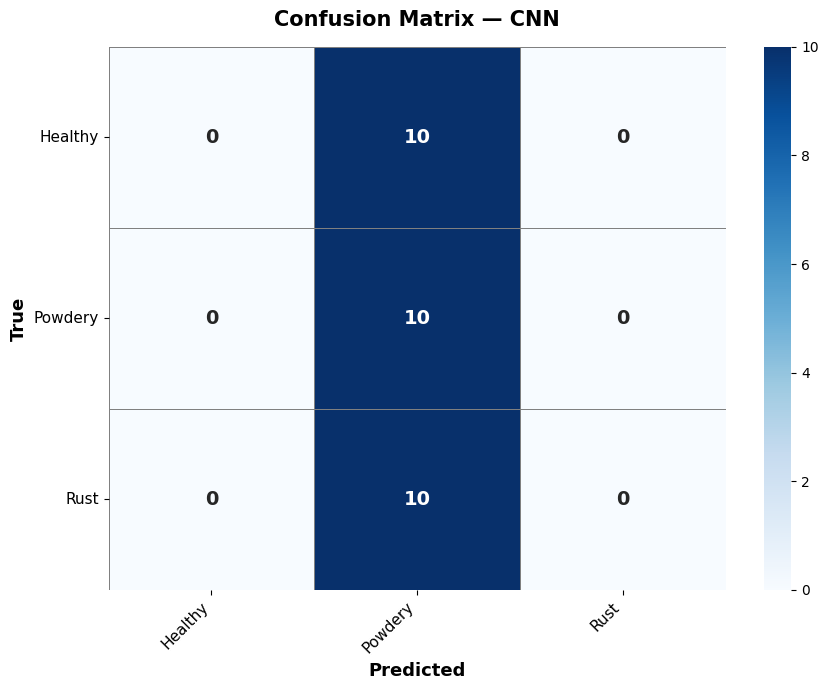

✅ Saved: /content/drive/MyDrive/CropSense AI/outputs/confusion_matrix_CNN.png

📊 Per-class accuracy:
   Healthy             : 0.00%
   Powdery             : 100.00%
   Rust                : 0.00%


In [22]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 21: CONFUSION MATRIX (FIXED)
# ═══════════════════════════════════════════════════════════════════════════

print("="*80)
print("CONFUSION MATRIX".center(80))
print("="*80)

# Ensure BEST_MODEL_NAME exists
if 'BEST_MODEL_NAME' not in globals():
    BEST_MODEL_NAME = max(model_results, key=lambda m: model_results[m]['accuracy'])

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[n.replace('_',' ') for n in label_encoder.classes_],
            yticklabels=[n.replace('_',' ') for n in label_encoder.classes_],
            linewidths=0.5, linecolor='gray',
            annot_kws={'size': 14, 'weight': 'bold'})

plt.xlabel('Predicted', fontsize=13, fontweight='bold')
plt.ylabel('True', fontsize=13, fontweight='bold')
plt.title(f'Confusion Matrix — {BEST_MODEL_NAME}', fontsize=15, fontweight='bold', pad=15)

plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/confusion_matrix_{BEST_MODEL_NAME}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Saved: {OUTPUT_DIR}/confusion_matrix_{BEST_MODEL_NAME}.png")

class_acc = cm.diagonal() / cm.sum(axis=1)

print(f"\n📊 Per-class accuracy:")
for cls, acc in zip(label_encoder.classes_, class_acc):
    print(f"   {cls:<20}: {acc*100:.2f}%")

print("="*80)

## CELL 22: Classification Report

In [23]:
print("="*80)
print("CLASSIFICATION REPORT".center(80))
print("="*80)

report = classification_report(
    y_true,
    y_pred_classes,
    target_names=label_encoder.classes_,
    digits=4
)

print(report)

report_dict = classification_report(
    y_true,
    y_pred_classes,
    target_names=label_encoder.classes_,
    output_dict=True,
    digits=4
)

pd.DataFrame(report_dict).T.to_csv(
    f'{OUTPUT_DIR}/classification_report_{BEST_MODEL_NAME}.csv'
)

print(f"💾 Saved: {OUTPUT_DIR}/classification_report_{BEST_MODEL_NAME}.csv")
print("="*80)

                             CLASSIFICATION REPORT                              
              precision    recall  f1-score   support

     Healthy     0.0000    0.0000    0.0000        10
     Powdery     0.3333    1.0000    0.5000        10
        Rust     0.0000    0.0000    0.0000        10

    accuracy                         0.3333        30
   macro avg     0.1111    0.3333    0.1667        30
weighted avg     0.1111    0.3333    0.1667        30

💾 Saved: /content/drive/MyDrive/CropSense AI/outputs/classification_report_CNN.csv


## CELL 23: Per-Class Performance

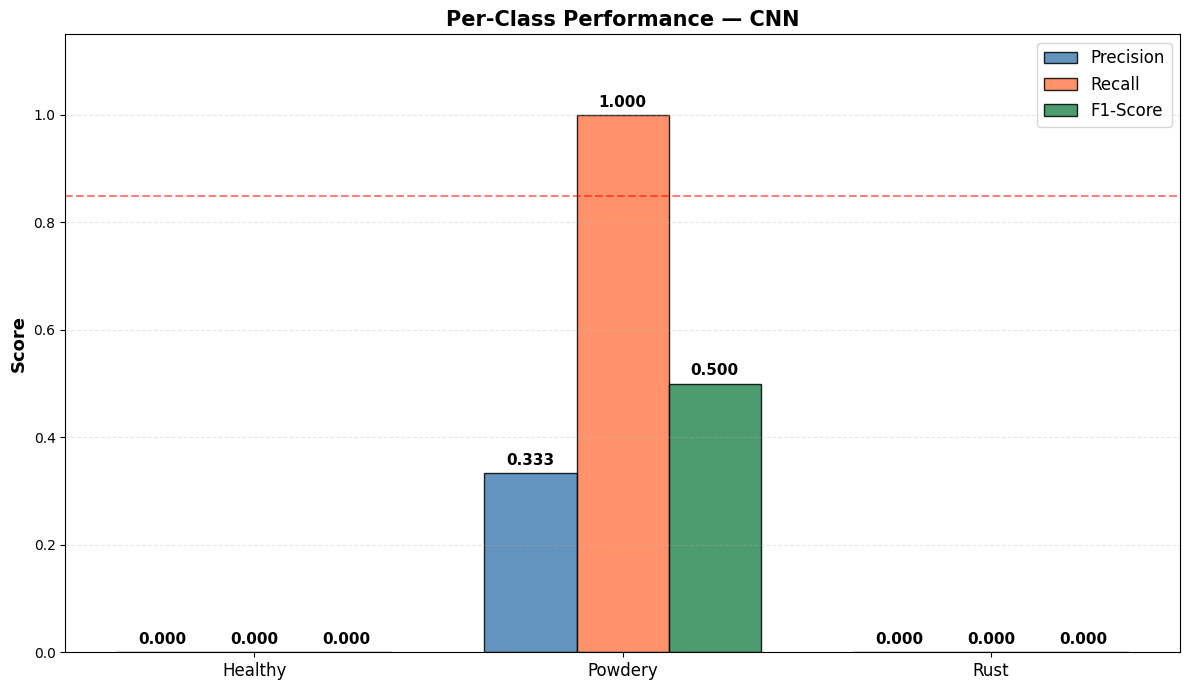

✅ Saved: /content/drive/MyDrive/CropSense AI/outputs/per_class_performance_CNN.png


In [24]:
precision_scores = [report_dict[c]['precision'] for c in label_encoder.classes_]
recall_scores    = [report_dict[c]['recall']    for c in label_encoder.classes_]
f1_scores        = [report_dict[c]['f1-score']  for c in label_encoder.classes_]

x = np.arange(num_classes)
w = 0.25
fig, ax = plt.subplots(figsize=(12, 7))

for vals, label, color, offset in [
    (precision_scores, 'Precision', 'steelblue', -w),
    (recall_scores,    'Recall',    'coral',      0),
    (f1_scores,        'F1-Score',  'seagreen',   w),
]:
    bars = ax.bar(x + offset, vals, w, label=label, color=color, alpha=0.85, edgecolor='black')
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.01,
                f'{h:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels([c.replace('_',' ') for c in label_encoder.classes_], fontsize=12)
ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_ylim([0, 1.15])
ax.set_title(f'Per-Class Performance — {BEST_MODEL_NAME}', fontsize=15, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=0.85, color='red', linestyle='--', linewidth=1.5, alpha=0.5)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/per_class_performance_{BEST_MODEL_NAME}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Saved: {OUTPUT_DIR}/per_class_performance_{BEST_MODEL_NAME}.png")

## CELL 24: ROC Curves

                               ROC CURVE ANALYSIS                               


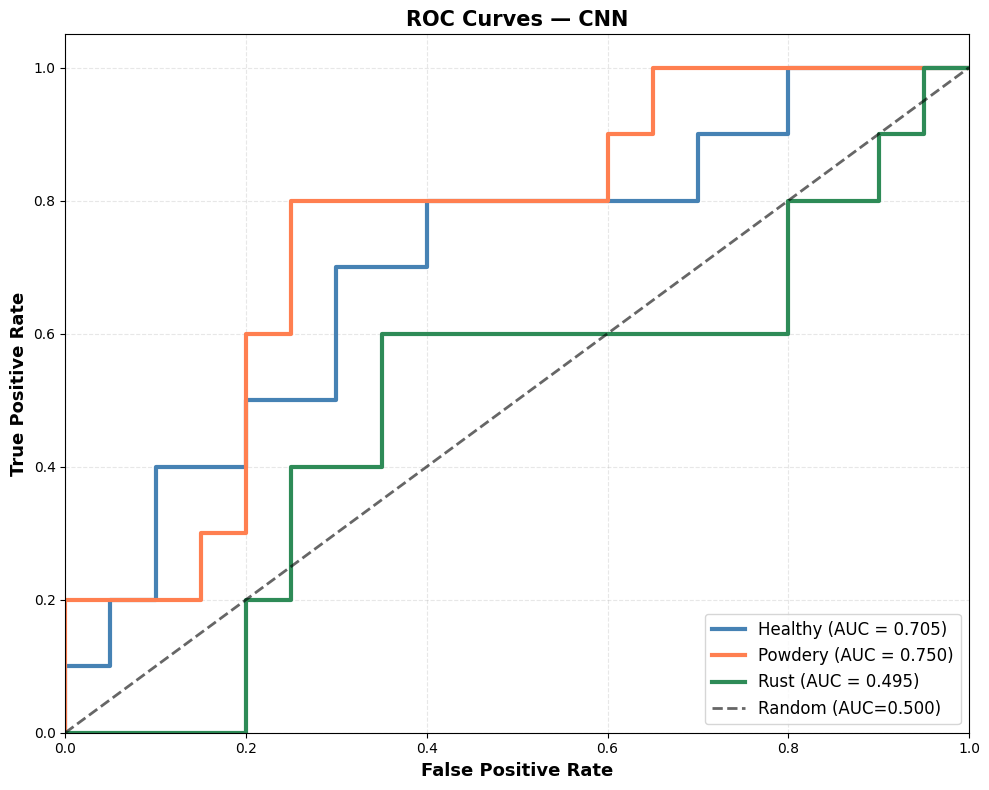


📊 AUC Scores:
  Healthy             : 0.7050
  Powdery             : 0.7500
  Rust                : 0.4950
   Mean AUC: 0.6500

✅ Saved: /content/drive/MyDrive/CropSense AI/outputs/roc_curves_CNN.png


In [25]:
print("="*80)
print("ROC CURVE ANALYSIS".center(80))
print("="*80)

y_true_bin = label_binarize(y_true, classes=range(num_classes))

fpr, tpr, roc_auc = {}, {}, {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

roc_colors = ['steelblue', 'coral', 'seagreen']

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=roc_colors[i], lw=3,
             label=f'{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0,1],[0,1],'k--', lw=2, label='Random (AUC=0.500)', alpha=0.6)
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate',  fontsize=13, fontweight='bold')
plt.title(f'ROC Curves — {BEST_MODEL_NAME}', fontsize=15, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/roc_curves_{BEST_MODEL_NAME}.png', dpi=300, bbox_inches='tight')
plt.show()

mean_auc = np.mean(list(roc_auc.values()))

print(f"\n📊 AUC Scores:")
for i, cls in enumerate(label_encoder.classes_):
    print(f"  {cls:<20}: {roc_auc[i]:.4f}")

print(f"   Mean AUC: {mean_auc:.4f}")
print(f"\n✅ Saved: {OUTPUT_DIR}/roc_curves_{BEST_MODEL_NAME}.png")
print("="*80)

## CELL 25: Prediction Examples

                              PREDICTION EXAMPLES                               


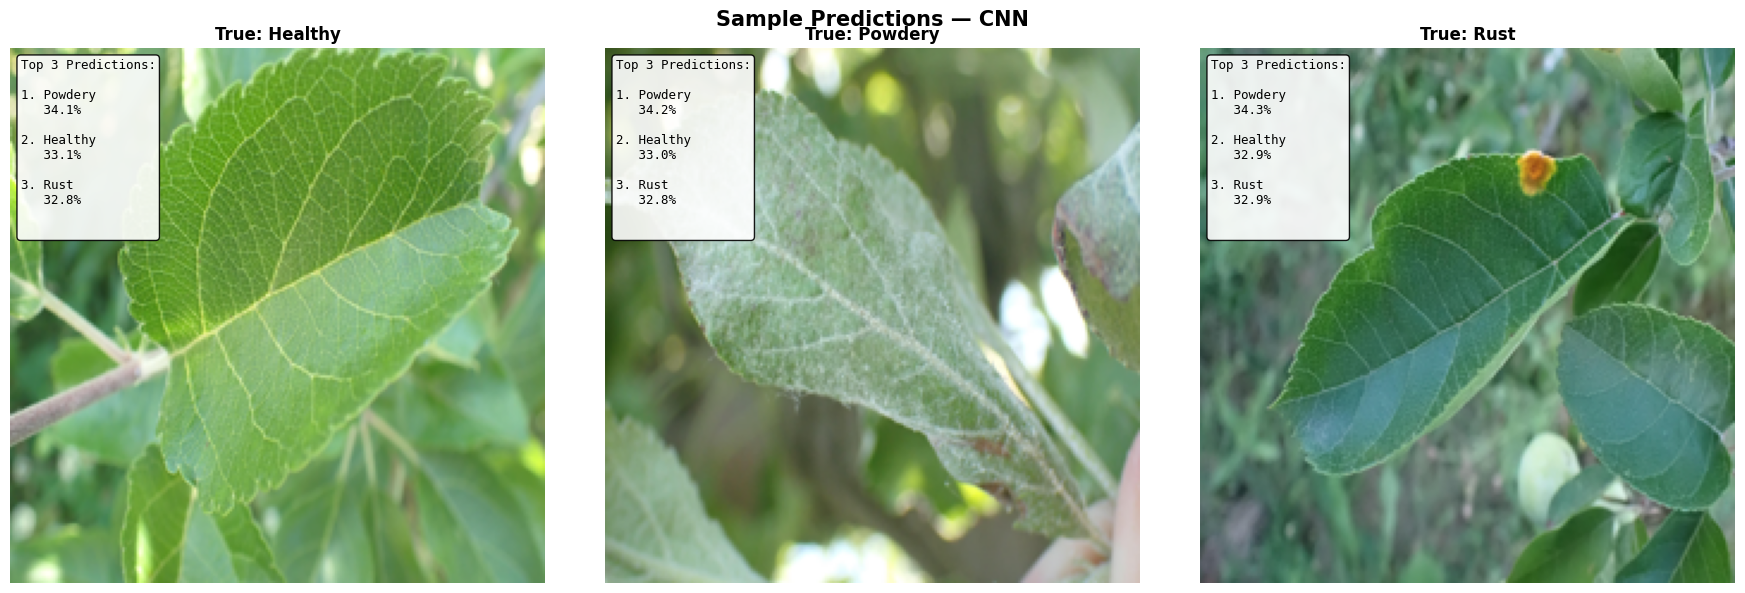

✅ Saved: /content/drive/MyDrive/CropSense AI/outputs/prediction_examples.png


In [26]:
print("="*80)
print("PREDICTION EXAMPLES".center(80))
print("="*80)

sample_imgs, sample_labels = [], []

for i in range(num_classes):
    idx_pool = np.where(y_true == i)[0]
    if len(idx_pool) > 0:
        sample_imgs.append(X_test[idx_pool[0]])
        sample_labels.append(i)

fig, axes = plt.subplots(1, len(sample_imgs), figsize=(6*len(sample_imgs), 6))
if len(sample_imgs) == 1:
    axes = [axes]

for ax, img, true_idx in zip(axes, sample_imgs, sample_labels):
    preds = best_model.predict(np.expand_dims(img, 0), verbose=0)[0]
    top3  = np.argsort(preds)[::-1][:3]

    ax.imshow(img)
    ax.axis('off')

    txt = "Top 3 Predictions:\n\n"
    for rank, ci in enumerate(top3, 1):
        txt += f"{rank}. {class_names[ci]}\n   {preds[ci]*100:.1f}%\n\n"

    ax.text(0.02, 0.98, txt, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', family='monospace',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

    ax.set_title(f'True: {class_names[true_idx]}', fontsize=12, fontweight='bold')

plt.suptitle(f'Sample Predictions — {BEST_MODEL_NAME}', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/prediction_examples.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Saved: {OUTPUT_DIR}/prediction_examples.png")
print("="*80)

## CELL 26: Save Best Model & Metadata

In [27]:
print("="*80)
print("SAVING BEST MODEL".center(80))
print("="*80)

final_path = f'{OUTPUT_DIR}/cropsense_final_{BEST_MODEL_NAME}.keras'
best_model.save(final_path)

print(f"\n✅ Final model saved: {final_path}")

print("\n📱 Converting to TFLite for mobile deployment...")
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open(TFLITE_PATH, 'wb') as f:
    f.write(tflite_model)

print(f"✅ TFLite model saved: {TFLITE_PATH}")
print(f"   TFLite size: {len(tflite_model)/1024:.1f} KB")

metadata = {
    'project': 'CropSense AI',
    'best_model': BEST_MODEL_NAME,
    'classes': class_names,
    'num_classes': num_classes,
    'input_shape': [IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS],
    'trained_on': datetime.now().strftime('%Y-%m-%d %H:%M')
}

with open(METADATA_PATH, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✅ Metadata saved: {METADATA_PATH}")

print("\n" + "="*80)
print("FINAL SUMMARY".center(80))
print("="*80)
print(f"\n  Best Model:  {BEST_MODEL_NAME}")
print(f"  Saved to:    {OUTPUT_DIR}/")
print(f"  TFLite:      {TFLITE_PATH}")
print("\n" + "="*80)
print(" CROPSENSE AI TRAINING COMPLETE!".center(80))
print("="*80)

                               SAVING BEST MODEL                                

✅ Final model saved: /content/drive/MyDrive/CropSense AI/outputs/cropsense_final_CNN.keras

📱 Converting to TFLite for mobile deployment...
Saved artifact at '/tmp/tmpn1wbpwro'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132891985953808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132891985955536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132891982742160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132891982744080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132891985955152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132891982742544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132891982743312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132